**CityGML Parsing & Mapillary Integration**

Task - 1 - Extract Building Footprints

Parse the GML file and extract the geometry of each building (footprint).
Plot all building footprints together on a single plot (e.g., using matplotlib, geopandas, or shapely)

CityGML version = 1.0
LoD             = 2


In [ ]:
import xml.etree.ElementTree as ET
import geopandas as gpd
import folium
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mlpPolygon
import matplotlib
import csv
import mapillary.interface as mly

In [15]:
tree = ET.parse(".\\690_5334.gml")
root = tree.getroot()
namespace = {
    "gml": "http://www.opengis.net/gml",
    "bldg": "http://www.opengis.net/citygml/building/1.0",
    "gen": "http://www.opengis.net/citygml/generics/1.0",
    "citygml": "http://www.opengis.net/citygml/1.0"
}

In [16]:
def get_building_footprints(buildings) -> list:
    building_ids = []
    footprints = []
    for building in buildings:
        building_ids.append(building.get("{http://www.opengis.net/gml}id"))
        ground_surface = building.findall(".//bldg:GroundSurface",namespaces=namespace)
        for surface in ground_surface:
            polygons = surface.findall(".//gml:Polygon",namespaces=namespace)
            for polygon in polygons:
                # Extracting the Coordinates and spliting based on whitespaces between them.
                poslist = polygon.find(".//gml:posList",namespaces=namespace).text.strip().split()
                xy_coords = [(float(poslist[i]),float(poslist[i+1])) for i in range(0,len(poslist),3)]
                z_coords = [float(poslist[i+2]) for i in range(0,len(poslist),3)]
                '''if len(set(z_coords)) ==1:
                   # All elevation levels are same inidcating a ground surface'''
                footprints.append(xy_coords)
    return building_ids, footprints

In [17]:
def mlpplot_building_footprints(building_ids,footprints):
  fig, ax = plt.subplots(figsize =(15,12))
  for coords in footprints:
    patch = mlpPolygon(coords, facecolor='lightblue', edgecolor='navy', alpha=0.7)
    ax.add_patch(patch)

  all_x = [x for coords in footprints for x,y in coords]
  all_y = [y for coords in footprints for x,y in coords]
  ax.set_xlim(min(all_x), max(all_x))
  ax.set_ylim(min(all_y), max(all_y))
  ax.set_aspect('equal')
  ax.set_title(f"Building Footprints ({len(footprints)} buildings)")
  ax.set_axis_off()
  plt.show()

In [25]:
def plot_building_footprints(building_ids, footprints):
    building_geometries = [Polygon(coords) for coords in footprints]
    area = [bld.area for bld in building_geometries]
    print(area)
    geo_dataframe = gpd.GeoDataFrame( {'building_ids':building_ids,'area':area},
                                geometry=building_geometries,
                                 crs  = 25832)
    map = geo_dataframe.explore(color='lightblue', style_kwds={'color': 'navy'}, popup= True)
    map.save('map.html')

Total Buildings Parsed 5479
5479 Extracted
[49.347750000033066, 107.53784999700994, 20.146920499667882, 213.86302200276796, 127.58165000163464, 76.49569800181723, 21.669616498944702, 269.184049998472, 249.32394999625706, 61.671540999486325, 209.45363249648076, 168.09258000462364, 313.2356499988894, 177.27755949148684, 380.81024999558014, 274.6693535012478, 27.9370149989141, 122.07272249781921, 147.53144299933754, 312.92796749655605, 70.38740000284673, 41.67160499769407, 149.6824964976934, 536.4478000101165, 40.27914499873745, 71.46033349611315, 49.89285549979151, 33.42097950162979, 30.349799998649267, 185.7199590001407, 65.37524999939801, 215.87070000164394, 79.29919999775403, 704.7545324908975, 38.374357998117, 57.901130500471304, 15.18020599939436, 411.1276999994963, 195.1276400021912, 129.09003699825337, 210.79534999844006, 47.78017400126678, 60.14185900217103, 542.6151860022409, 267.01167599920876, 20.053851501034558, 183.02375000321422, 323.65339499542955, 12.394044999522084, 88.9

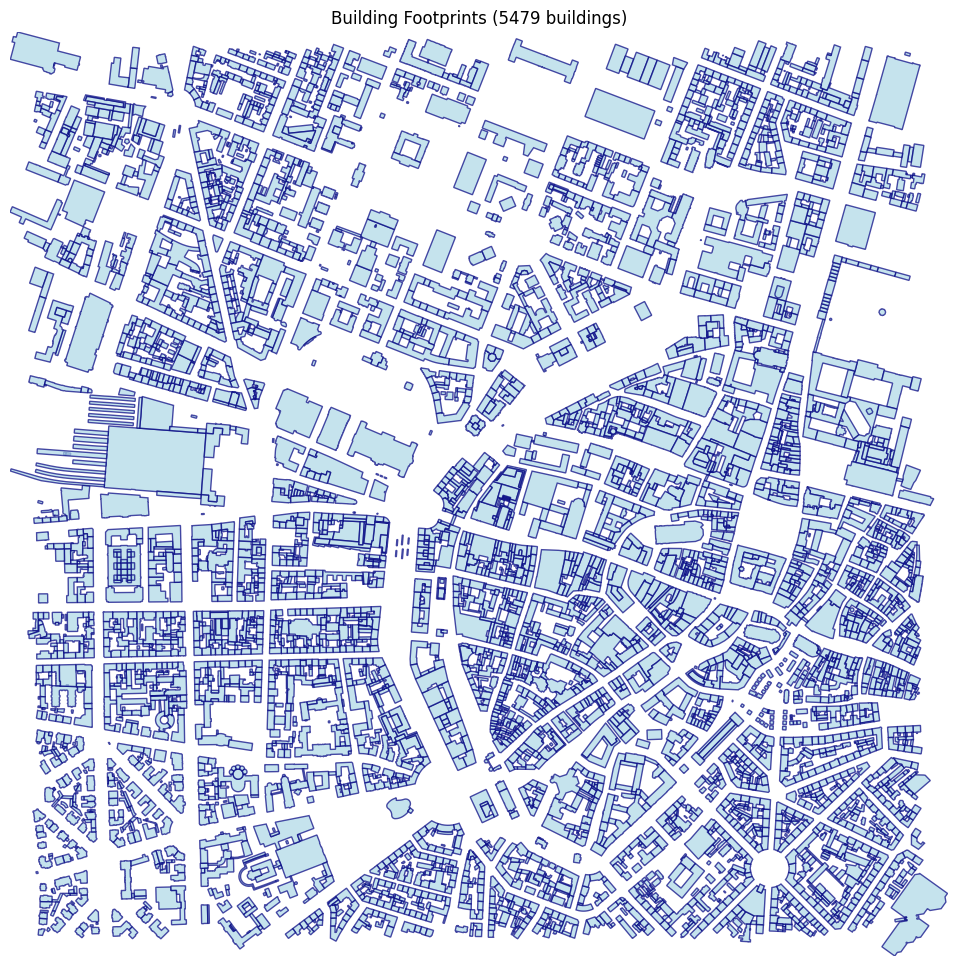

In [26]:
buildings = root.findall(".//bldg:Building",namespaces=namespace)
if buildings:
    print(f'Total Buildings Parsed {len(buildings)}')
    building_ids, footprints = get_building_footprints(buildings)
    print(f"{len(footprints)} Extracted")
    plot_building_footprints(building_ids,footprints)
    mlpplot_building_footprints(building_ids,footprints)
else:
    print("No Buildings Found!")


2. Extract Building Attributes
o Parse and list available attributes for each building (e.g., name, number of
storeys, building function, etc.).
o Present the extracted data in a readable format (CSV or printed summary).

In [13]:
buildings_attributes = []
for building in buildings:
  building_data = {}
  if building:
    building_data['ID'] = building.get('{http://www.opengis.net/gml}id')
    name = building.find(".//citygml:externalReference/citygml:externalObject/citygml:name",namespaces=namespace)
    building_data['Name'] = name.text if name is not None else None
    location = building.find('.//gen:stringAttribute[@name="DatenquelleLage"]/gen:value',namespaces=namespace)
    building_data['Location'] = location.text if location is not None else None
    community = building.find('.//gen:stringAttribute[@name = "Gemeindeschluessel"]/gen:value',namespaces=namespace)
    building_data['Community'] = community.text if community is not None else None
    function = building.find('bldg:function',namespaces=namespace)
    building_data['Function'] = function.text if function is not None else None
    roof_type = building.find('bldg:roofType',namespaces=namespace)
    building_data['Roof Type'] = roof_type.text if roof_type is not None else None
    storeys = building.find('bldg:storeysAboveGround',namespaces=namespace)
    building_data['Storeys'] = int(storeys.text) if storeys is not None else None
    height = building.find('bldg:measuredHeight',namespaces=namespace)
    building_data['Building Height'] = float(height.text) if height is not None else None
    area = building.find('.//bldg:GroundSurface/gen:stringAttribute[@name="Flaeche"]/gen:value', namespace)
    building_data['Ground Surface Area'] =  area.text if area is not None else None
    building_coords = building.find('.//bldg:GroundSurface', namespace).find(".//gml:Polygon",namespace).find(".//gml:posList",namespace).text.strip().split()
    building_coords = [(float(i),float(i+1)) for i in range(0, len(building_coords),3)]
    building_data['centroid'] = Polygon(building_coords).centroid
    buildings_attributes.append(building_data)

headers = list(buildings_attributes[0].keys())
with open('building.csv','w',newline='') as file:
      writer = csv.DictWriter(file,fieldnames=headers)
      writer.writeheader()
      writer.writerows(buildings_attributes)

C:\Users\veena\AppData\Local\Temp\ipykernel_36260\713291241.py:4: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  if building:


Bonus Task:
3. Retrieve Building Images from Mapillary
o For each building, use the Mapillary Python SDK to search and download
street-level images around it within a 50m radius. Print the image IDs.
o Provide sample code showing how to access Mapillary images via API.
o Tip: you may need to register a developer account to get a valid access token.


In [ ]:
my_token = 'MLY|24215326238121314|600b117c12634ee0abb9bbb5ba7a6d6a'
mly.set_access_token(my_token)
d = {'col1': ['name1',],'geometry':[Point(689943.8,5333949.88),]}
gdf = gpd.GeoDataFrame(d, crs=25832)
print(gdf.crs)
gdf = gdf.to_crs(4326) #Ouput is in the form of  Longitude and Latitude
print(gdf['geometry'][0].x)
data = mly.get_image_close_to(longitude= gdf['geometry'][0].x, latitude= gdf['geometry'][0].y,radius = 50,)
print(data)